# Gradient Boosting Machine (GBM)

### 📘 Notebook Overview: Developing GBM Model

This notebook focuses on building and evaluating a Gradient Boosting Machine (GBM) model to predict income levels in the Adult Census dataset. The process includes preprocessing, training, model persistence, and threshold optimization. The following sections are included:

---

### ▪️ Importing Required Packages  
All necessary Python packages and libraries are imported to support preprocessing, modeling, and evaluation tasks.

### ▪️ Data Preprocessing  
Features are encoded and scaled to input into the GBM model.

### ▪️ Training GBM Model  
A GBM classifier is trained on the training data using **GridSearchCV** for hyperparameter tuning. The process is parallelized using the `n_jobs` parameter to optimize computation time and find the best combination of parameters for model performance.

### ▪️ Save the Model  
The trained model is saved using `joblib` for easy reuse without retraining.

### ▪️ Load and Evaluate the Model  
The saved model is reloaded and evaluated on the test set using classification metrics such as accuracy, precision, recall, and F1-score.

### ▪️ Find Best Threshold Value with AUC-PR  
AUC-PR (Area Under the Precision-Recall Curve) is used to identify the optimal threshold for classification, improving the model's performance on the minority class.

---


## Importing Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, 
    f1_score, 
    average_precision_score, 
    accuracy_score, 
    balanced_accuracy_score,
    precision_recall_curve,
    auc,
)

import time
import joblib

## Data Preprocessing

In this section, I prepared the data before training the GBM model. The main preprocessing steps were:

#### 1. Loading the Datasets
- Loaded the training and testing datasets that had already undergone imputation and feature selection.

#### 2. Encoding the Target Variable
- Used `LabelEncoder` to convert the target variable `income` into numeric values (0 and 1), making it suitable for model training.

#### 3. Identifying Feature Types
- Separated the features into numeric and categorical columns to handle them appropriately during preprocessing.

#### 4. Encoding Categorical Features
- Applied one-hot encoding to transform categorical variables into a binary format that machine learning models can process.

#### 5. Aligning Columns
- After one-hot encoding, aligned the test set columns to match the training set structure, filling any missing columns with zeros.

#### 6. Separating Features and Labels
- Split the datasets into input features (`X_train`, `X_test`) and target labels (`y_train`, `y_test`) for model training and evaluation.

#### 7. Standardizing Numeric Features
- Standardized the numeric columns using `StandardScaler` to ensure that all numeric features have a mean of 0 and a standard deviation of 1.
- This step helps improve model performance, especially for algorithms sensitive to feature scaling.


In [2]:
# Load datasets
train_df = pd.read_csv("adult_combined_train_80_imputed_feature_selected.csv")
test_df = pd.read_csv("adult_combined_test_20_imputed_feature_selected.csv")

# Encode target variable with LabelEncoder
label_enc = LabelEncoder()
train_df["income"] = label_enc.fit_transform(train_df["income"])
test_df["income"] = label_enc.transform(test_df["income"])

# Identify numeric and categorical features
numeric_cols = train_df.select_dtypes(include=["int64", "float64"]).drop("income", axis=1).columns
categorical_cols = train_df.select_dtypes(include=["object"]).columns

# One-Hot Encode categorical features
train_df = pd.get_dummies(train_df, columns=categorical_cols)
test_df = pd.get_dummies(test_df, columns=categorical_cols)

# Align test set columns with train set
test_df = test_df.reindex(columns=train_df.columns, fill_value=0)

# Separate features and labels
X_train = train_df.drop("income", axis=1)
y_train = train_df["income"]
X_test = test_df.drop("income", axis=1)
y_test = test_df["income"]

# Apply StandardScaler to numeric columns
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [3]:
label_enc.classes_

array(['<=50K', '>50K'], dtype=object)

## Training GBM Model

In this section, I trained a Gradient Boosting Machine (GBM) model using hyperparameter tuning with `GridSearchCV`. The main steps are:

#### 1. Define the GBM Model
- Initialized a `GradientBoostingClassifier` with a fixed `random_state` to ensure reproducibility.

#### 2. Set Up Hyperparameters
- Defined a wider range of hyperparameters for tuning.

#### 3. Hyperparameter Tuning with GridSearchCV
- Used `GridSearchCV` to perform an exhaustive search over the provided hyperparameter grid.
- Set `cv=5` for 5-fold cross-validation.
- Used `n_jobs=-1` to utilize all available CPU cores for parallel processing and `verbose=1` for printing basic information.

#### 4. Model Training
- Fitted the GBM model to the training data (`X_train`, `y_train`) using the grid search setup.

#### 5. Tracking Training Time
- Measured and printed the total training time in both seconds and minutes to monitor resource usage and efficiency.


In [4]:
start_time = time.time()

# Define GBM and parameters
gbm = GradientBoostingClassifier(random_state=42)

'''
gbm_params = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 5]
}

'''

# Best Parameters (received after the training) 
gbm_params = {
    "n_estimators": [200],
    "learning_rate": [0.1],
    "max_depth": [5],
    "min_samples_split": [2],
    "min_samples_leaf": [5]
}

# GridSearchCV
gbm_grid = GridSearchCV(gbm, gbm_params, cv=5, n_jobs=-1, verbose=1)
gbm_grid.fit(X_train, y_train)

end_time = time.time()
print(f"Training time: {(end_time - start_time):.2f} seconds ({(end_time - start_time)/60:.2f} minutes)")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training time: 26.37 seconds (0.44 minutes)


In [5]:
print("Best parameters found by GridSearchCV:")
print(gbm_grid.best_params_)

Best parameters found by GridSearchCV:
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}


## Save the Model

In [6]:
# Save the best model
joblib.dump(gbm_grid.best_estimator_, "gbm_model.pkl")
print("✅ GBM model saved as 'gbm_model.pkl'")

✅ GBM model saved as 'gbm_model.pkl'


## Load and Evaluate the Model

In this section, I loaded the saved GBM model and evaluated its performance on the test set. The key steps were:

#### 1. Loading the Saved Model
- Used `joblib.load` to load the previously saved GBM model (`gbm_model.pkl`).

#### 2. Making Predictions
- Generated class predictions (`gbm_preds`) for the test set.
- Also obtained the predicted probabilities (`gbm_probs`) for calculating probability-based metrics.

#### 3. Evaluating the Model
- Printed the best hyperparameters found during training.
- Evaluated the model using various performance metrics:
  - **Classification Report:** Displays precision, recall, f1-score, and support for each class.
  - **Balanced Accuracy Score:** Accounts for imbalanced datasets by averaging recall across classes.
  - **Accuracy Score:** Measures the overall correctness of predictions.
  - **F1 Score:** Harmonic mean of precision and recall, useful when classes are imbalanced.
  - **AUC-PR (Area Under the Precision-Recall Curve):** Measures the trade-off between precision and recall, especially important for imbalanced datasets.


In [7]:
# Load the saved model
loaded_gbm = joblib.load("gbm_model.pkl")
gbm_preds = loaded_gbm.predict(X_test)
gbm_probs = loaded_gbm.predict_proba(X_test)[:, 1]

# Evaluate the loaded model
print("\n📌 GBM - Best Parameters:", gbm_grid.best_params_)
print("\n📊 Classification Report:\n", classification_report(y_test, gbm_preds))
print("✅ Balanced Accuracy Score:", balanced_accuracy_score(y_test, gbm_preds))
print("✔️ Accuracy:", accuracy_score(y_test, gbm_preds))
print("🎯 F1 Score:", f1_score(y_test, gbm_preds))
print("📈 AUC-PR:", average_precision_score(y_test, gbm_probs))



📌 GBM - Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      7310
           1       0.78      0.66      0.72      2295

    accuracy                           0.88      9605
   macro avg       0.84      0.80      0.82      9605
weighted avg       0.87      0.88      0.87      9605

✅ Balanced Accuracy Score: 0.8027942443127122
✔️ Accuracy: 0.8756897449245185
🎯 F1 Score: 0.7182633317602642
📈 AUC-PR: 0.8332597534952035


## Find Best Threshold Value with AUC-PR

In this section, I analyzed the model's precision-recall performance and selected the best decision threshold to maximize the F1 score. The main steps were:

#### 1. Calculate Precision, Recall, and Thresholds
- Used `precision_recall_curve` to compute precision, recall, and threshold values based on the model's predicted probabilities.

#### 2. Calculate AUC-PR
- Computed the **Area Under the Precision-Recall Curve (AUC-PR)** using the `auc` function.

#### 3. Find the Best Threshold
- Calculated the F1 score at each threshold.
- Identified the threshold that gave the **highest F1 score**, indicating the best balance between precision and recall.

#### 4. Visualize the Precision-Recall Curve
- Plotted the precision-recall curve.
- Highlighted the point corresponding to the best threshold to visualize where the model performs best.

#### 5. Apply the Best Threshold
- Converted predicted probabilities into binary class predictions based on the best threshold.
- Re-evaluated model performance using:
  - **Classification Report** (precision, recall, F1-score)
  - **Balanced Accuracy Score**
  - **Accuracy**
  - **F1 Score**

Using a custom threshold (instead of the default 0.5) helps to better optimize model performance, especially in cases of class imbalance.


📈 AUC-PR (using auc): 0.8332622014310535

🔥 Best Threshold = 0.4574
🎯 Best F1 Score = 0.7330


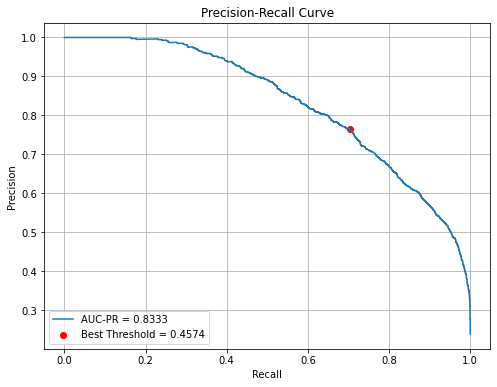


📊 Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      7310
           1       0.77      0.70      0.73      2295

    accuracy                           0.88      9605
   macro avg       0.84      0.82      0.83      9605
weighted avg       0.87      0.88      0.88      9605

✅ Balanced Accuracy Score: 0.8177762577899377
✔️ Accuracy: 0.87756376887038
🎯 F1 Score: 0.7329700272479565


In [8]:
# Calculate precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, gbm_probs)

# Calculate AUC-PR
auc_pr = auc(recall, precision)
print("📈 AUC-PR (using auc):", auc_pr)

# Calculate F1 scores for each threshold (length of thresholds = len(precision) - 1)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n🔥 Best Threshold = {best_threshold:.4f}")
print(f"🎯 Best F1 Score = {best_f1:.4f}")

# Plot PR Curve and mark best threshold
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.4f}')
plt.scatter(recall[best_idx], precision[best_idx], color='red', label=f'Best Threshold = {best_threshold:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# Apply best threshold to get predicted class labels
y_pred_best = (gbm_probs >= best_threshold).astype(int)

# Print classification report using best threshold
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred_best))
print("✅ Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred_best))
print("✔️ Accuracy:", accuracy_score(y_test, y_pred_best))
print("🎯 F1 Score:", f1_score(y_test, y_pred_best))
